# The Market Making Problem

### Import the necessary libraries

In [35]:
import time
import copy
import random
import sys

import numpy as np
import pandas as pd

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from tqdm.notebook import tqdm 

%matplotlib inline

### Setting up  
#### Setting some global parameters  

In [36]:
EPSILON = 0.5 # Probability for exploration

ALPHA = 0.05 # Step size

GAMMA = 1 # Discount factor for Q-Learning and Sarsa

In [37]:
ACTIONS = [0, 1, 2] # Possible actions

NUM_INV_STEPS = 3 # Number of inventory states: long, short, flat

NUM_PROB_STEPS = 10 # Number of discrete probabilities

# Dimensions of the action-state value array:
Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS))

FILL_PROBS = np.linspace(0, 1, 10) # Possible probability values

c = 0.008

MAX_ITER = float('inf') # Maximum number of iterations in one episode
# (with `MAX_ITER = np.float('inf')`, the entire dataset will be used)

In [38]:
FILL_PROBS

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [39]:
actions = {'buy': 2, 'sell': 0, 'hold': 1} 
positions = {'flat': 0, 'long': 2, 'short': 1}

In [40]:
class DataFeed(object):
    def __init__(self, data_RA):
        self.data_RA = data_RA
        self.rewind()
    def next(self):
        try:
            return self.__gen.__next__()
        except StopIteration as e:
            raise e
    def rewind(self):
        self.__gen = (row for row in self.data_RA)

In [41]:
t = pd.read_csv('LKOH20150310.csv')
t.head()

,Time,BidPrice1,BidVolume1,AskPrice1,AskVolume1,Last Trade Price,Last Trade Volume,Side,isNewTrade,LastDealTime,...,BidLiquidityRatio,FutureVWAP1,FutureVWAP30,FutureVWAP60,Difference1,Difference30,Difference60,IsUp1,IsUp30,IsUp60
0,1900-01-01 10:00:02.013,2787.2,246.0,2789.0,201.0,2788.9,19.0,1.0,0.0,100001988.0,...,0.550336,2791.158259,2791.139716,2788.789634,6.227369,9.170860,6.820778,1.0,1.0,1.0
1,1900-01-01 10:00:02.036,2787.2,166.0,2789.0,201.0,2787.2,80.0,1.0,-1.0,100002036.0,...,0.452316,2791.191749,2791.139716,2788.789634,5.328342,8.930348,6.580266,1.0,1.0,1.0
2,1900-01-01 10:00:02.047,2787.2,161.0,2789.0,201.0,2787.2,5.0,1.0,0.0,100002047.0,...,0.444751,2791.191749,2791.139716,2788.789634,5.328342,8.930348,6.580266,1.0,1.0,1.0
3,1900-01-01 10:00:02.191,2787.3,40.0,2789.0,201.0,2787.2,5.0,1.0,0.0,100002047.0,...,0.165975,2791.379439,2791.139716,2788.789634,5.516032,8.930348,6.580266,1.0,1.0,1.0
4,1900-01-01 10:00:02.373,2787.3,40.0,2789.0,195.0,2789.0,6.0,1.0,1.0,100002373.0,...,0.170213,2791.348007,2790.852239,2788.789634,3.786242,8.605351,6.542746,1.0,1.0,1.0


In [42]:
data = t[['AskPrice1', 'AskVolume1', 'BidPrice1', 'BidVolume1']]
data.head()

,AskPrice1,AskVolume1,BidPrice1,BidVolume1
0,2789.0,201.0,2787.2,246.0
1,2789.0,201.0,2787.2,166.0
2,2789.0,201.0,2787.2,161.0
3,2789.0,201.0,2787.3,40.0
4,2789.0,195.0,2787.3,40.0


## Need to delete duplicates in data to work only with updates in 1st level of LOB

In [43]:
data.drop_duplicates(inplace=True)

<ipython-input-43-515f69ef7765>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)


In [44]:
data_RA = np.array(data)
data_generator = DataFeed(data_RA)

## Environment

In [45]:
class Env(object):
    """Abstract class for an environment. Simplified OpenAI API.
    """

    def __init__(self):
        self.n_actions = None
        self.state_shape = None

        
    def step(self, action):
        """Run one timestep of the environment's dynamics.
        Accepts an action and returns a tuple (observation, reward, done, info).
        Args:
            action (numpy.array): action array
        Returns:
            tuple:
                - observation (numpy.array): Agent's observation of the current environment.
                - reward (float) : Amount of reward returned after previous action.
                - done (bool): Whether the episode has ended, in which case further step() calls will return undefined results.
                - info (str): Contains auxiliary diagnostic information (helpful for debugging, and sometimes learning).
        """
        raise NotImplementedError()

        
    def reset(self):
        """Reset the state of the environment and returns an initial observation.
        Returns:
            numpy.array: The initial observation of the space. Initial reward is assumed to be 0.
        """
        raise NotImplementedError()

        
    def render(self):
        """Render the environment.
        """
        raise NotImplementedError()

In [46]:
class SpreadTrading(Env):
    """Class for a discrete (buy/hold/sell) spread trading environment.
    """

    _actions = {'buy': 2, 'sell': 0, 'hold': 1} 

    _positions = {'flat': 0, 'long': 2, 'short': 1}

    
    def __init__(self, data_generator=data_generator, EPSILON = 0.5, ALPHA = 0.05, GAMMA = 1, ACTIONS = [0, 1, 2], NUM_INV_STEPS = 3, NUM_PROB_STEPS = 10, Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS)), FILL_PROBS = np.linspace(0, 1, 10), 
c = 0.008, MAX_ITER = float('inf'), cash_limit_total = 1000000, cash_deal_limit = 50000, history_length=2, amount_own = 0):

        self._data_generator = data_generator
        self._EPSILON = EPSILON
        self._c = c
        self._ALPHA = ALPHA
        self._GAMMA = GAMMA
        #не уверена, что нужно ещё здесь прописывать actions потому что выше уже указала - ???
        self._ACTIONS = ACTIONS
        self._NUM_INV_STEPS = NUM_INV_STEPS
        self._NUM_PROB_STEPS = NUM_PROB_STEPS
        self._Q_DIMS = Q_DIMS
        self._FILL_PROBS = FILL_PROBS
        self._MAX_ITER = MAX_ITER
        self._cash_limit_total = cash_limit_total
        self._cash_deal_limit = cash_deal_limit
        self._amount_own = amount_own
        
        #доп селфы с оригинального класса - пока не знаю зачем они
        self._first_render = True
        #self._history_length = history_length
        #self._prices_history = []
        #self._depths_history = []
        self.n_actions = 3
        self.reset()
      
    
    ##перенесём пока в reset всё из функции get_initial_state, потому что мне кажется, что это одно и то же)
    def reset(self):
        """Reset the trading environment. Reset rewards, data generator...
        Returns:
            initial state (tuple): initial state
        """
        self._iteration = 0
        self._data_generator.rewind()
        self._total_reward = 0
        self._total_pnl = 0
        self._position = self._positions['flat']
        self._entry_price = None
        self._cash_limit_total = 1000000
        #наверное, exit price нужно поставить ту что запомнил
        self._exit_price = None
        self._closed_plot = False
        self._amount_own = 0
        
        self._ask, self._ask_depth, self._bid, self._bid_depth = self._data_generator.next()
        self._price = {'bid': self._bid, 'ask': self._ask}
        
        self._q = self._bid_depth / (self._bid_depth + self._ask_depth)
        self._q_ind = int(self._q * self._NUM_PROB_STEPS)

        self._bid_vol = self._cash_deal_limit/self._price['bid']
        self._ask_vol = self._cash_deal_limit/self._price['ask']
        
        #агент должен действовать в рамках лоба, иначе, наверное, нельзя будет сделать бектест
        if self._bid_vol < self._bid_depth:
            self._bid_vol = self._bid_vol
        else:
            self._bid_vol = self._bid_depth
        
        if self._ask_vol < self._ask_depth:
            self._ask_vol = self._ask_vol
        else:
            self._ask_vol = self._ask_depth
    
        initial_state = self._position, self._q_ind, self._price, self._entry_price, self._bid_depth, self._ask_depth, self._bid_vol, self._ask_vol, self._cash_limit_total, self._amount_own
    
        return initial_state
      
    
    def step(self, action):
        
        done = False
        
        self._iteration += 1
        instant_pnl = 0
        reward = 0 
        #done = False
        
        # The ask/bid fill probabilities always sum to 1, meaning
        # that either bid or ask orders can always be executed
        if self._FILL_PROBS[self._q_ind] < np.random.rand():
            fill_bid = True
            fill_ask = False
        else:
            fill_bid = False
            fill_ask = True
        
        # Calculate the result of taking the selected action
        #если агент выставляет заявку на покупку и она исполняется  
        if (action == self._actions['buy']) and (fill_bid) and (self._cash_limit_total > 0):
            #задаём издержки за сделку
            reward = -self._c
            #если сейчас позиция "флэт" и исполняется поставленная  заяка на покупку, то 
            if (self._position == self._positions['flat']):  
                #меняем позицию на лонг
                self._position = self._positions['long']
                #указываем входную цену
                self._entry_price = self._price['bid']
                #пересчитываем объём, который агент может купить по новой цене покупки 
                #с учётом лимита на сделку
                #уменьшаем кэш с учётом объёма и цены покупки            
                self._cash_limit_total -= self._bid_vol*self._entry_price
                #увеличиваем число акции которое есть у агента в inventory
                self._amount_own += self._bid_vol
            elif(self._position == self._positions['short']): # closing out a short position          
                self._position = self._positions['flat']
                self._exit_price =  self._price['bid']
                #прибыль/убыток от закрытия короткой позиции
                instant_pnl = self._bid_vol*(self._entry_price - self._exit_price)*(1-self._c)
                self._entry_price = None                         
            elif (self._position == self._positions['long']):
                raise ValueError("can't buy already got")
                #предположим, что агент может поставить заявку на покупу, когда в лонге (хочет добавить акции в портфель)
       
        
        elif (action == self._actions['sell']) and (fill_ask):
            reward = -self._c
            if (self._position == self._positions['flat']):
                self._position = self._positions['short']
                self._entry_price = self._price['ask']
                self._cash_limit_total += self._ask_vol*self._entry_price
                self._amount_own -= self._ask_vol
            elif (self._position == self._positions['long']): # closing out a long position   
                self._exit_price = self._price['ask']
                self._position = self._positions['flat']
                instant_pnl = self._ask_vol*(self._exit_price - self._entry_price)*(1-self._c)
                self._entry_price = None
            elif (self._position == self._positions['short']):
                raise ValueError("can't sell already short")

        reward += instant_pnl
        self._total_pnl += instant_pnl
        self._total_reward += reward
        
        
        try:            
            # Get the next limit order book update
            self._ask, self._ask_depth, self._bid, self._bid_depth = self._data_generator.next()
            
            # Calculate the price and bid/ask fill probabilities for the next state
            self._price = {'bid': self._bid, 'ask': self._ask}

            # Estimate the fill probability
            self._q = self._bid_depth / (self._bid_depth + self._ask_depth)
            
            # Quantise q and scale it to the integer index 
            # q_ind is an index of the vector `FILL_PROBS`
            self._q_ind = int(self._q * self._NUM_PROB_STEPS) 
            
            #считаем кол-во которое можно купить/продать на следующей итерации
            self._bid_vol = self._cash_deal_limit/self._price['bid']
            self._ask_vol = self._cash_deal_limit/self._price['ask']
    
            if self._bid_vol < self._bid_depth:
                self._bid_vol = self._bid_vol
            else:
                self._bid_vol = self._bid_depth
        
            if self._ask_vol < self._ask_depth:
                self._ask_vol = self._ask_vol
            else:
                self._ask_vol = self._ask_depth
            
        except StopIteration as e:
            # This happens when the data generator reaches the end of the dataset
            #raise e
            #return e
            #print('Data finished')
            done = True
        
        next_state = self._position, self._q_ind, self._price, self._entry_price, self._bid_depth, self._ask_depth, self._bid_vol, self._ask_vol, self._cash_limit_total, self._amount_own
        
        return next_state, reward, done
    

In [47]:
environment = SpreadTrading()

In [48]:
def transform(next_state):
    new_next_state = []
    for i in next_state:
        i = list(i)
        bid = i[2]['bid']
        ask = i[2]['ask']
        del i[2]
        i.insert(2, bid)
        i.insert(3, ask)
        new_next_state.append(i)
    return new_next_state

## Agent

In [49]:
class Agent:
    
    _actions = {'buy': 2, 'sell': 0, 'hold': 1}
    _positions = {'flat': 0, 'long': 2, 'short': 1}
    
       
    def __init__(self,
                 state_size,
                 action_size,
                 episode_length,
                 memory_size=2000,
                 train_interval=100,
                 gamma=1,
                 learning_rate=0.001,
                 batch_size=64,
                 epsilon_min=0.01,
                 step_size=0.05,
                 expected=False,
                 max_iter = np.float('inf'),
                 ACTIONS = [0, 1, 2],
                 environment = environment,
                 episodes=150,
                 epoch_length = 15,
                 NUM_INV_STEPS = 3,
                 NUM_PROB_STEPS = 10
                 ):
        self.environment = environment
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size = memory_size
        self.step_size = step_size
        self.expected = expected
        self.max_iter = max_iter
        self.epoch_length = epoch_length
        self.memory = [None] * memory_size
        self.gamma = gamma
        self.epsilon = 0.5
        self.epsilon_min = epsilon_min
        self.epsilon_decrement = (self.epsilon - epsilon_min)\
            * train_interval / (episodes * episode_length)  # linear decrease rate
        self.Q_DIMS = (NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS))
        self.ACTIONS = ACTIONS
        self.learning_rate = learning_rate
        self.episodes = episodes
        self.train_interval = train_interval
        self.batch_size = batch_size
        #здесь надо попробовать вызвать функцию, иначе ошибка - не может предиктить, потому что забирает не рез функции, а вызывает её
        self.brain = self._build_brain()
        self.act = self._act
        self.sarsa = self._sarsa
        self.q_learning = self._q_learning
        self.i = 0
    
       
    def _build_brain(self):
        '''Build the agent's brain'''
        
        brain = Sequential()
        neurons_per_layer = 24
        activation = "relu"
        #добавила 1, так я удалила словарь из списка и заменила его на отдельных элемента (цена бид и цена аск), т.е -2 + 1
        brain.add(Dense(neurons_per_layer,
                        input_dim=self.state_size + 1,
                        activation=activation))
        brain.add(Dense(neurons_per_layer, activation=activation))
        brain.add(Dense(self.action_size, activation='linear'))
        brain.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return brain
    
        
    def _sarsa(self, q_value, eps):
        state = self.environment.reset()
        action = self.act(state, q_value, eps)
        rewards = 0.0
        done = False
        iteration = 0
            
        while (iteration < self.max_iter) and not done:
            # The step function will raise StopIteration when there
            # is no more data available to calculate the next state:
            try:
                next_state, reward, done = self.environment.step(action)
            except StopIteration:
                # Skip the rest of the loop and end the episode.
                # As there is no new `next_state`, updating
                # q_value again doesn't make sense
                done = True
                continue
                        
            next_action = self.act(next_state, q_value, eps)
            rewards += reward

        
            if not self.expected:
                target = q_value[next_state[0], next_state[1], next_action]
            else:
                # Calculate the expected value of new state for expected SARSA
                target = 0.0
                q_next = q_value[next_state[0], next_state[1], :]
                best_actions = np.argwhere(q_next == np.max(q_next))
                for action_ in self.ACTIONS: 
                    if action_ in best_actions:
                        target += ((1.0 -  eps) / len(best_actions) 
                                   +  eps / len(self.ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                    else:
                        target +=  eps / len(self.ACTIONS) * q_value[next_state[0], next_state[1], action_]
            target *= self.gamma
        
            # SARSA update
            q_value[state[0], state[1], action] += self.step_size * (reward
                        + target - q_value[state[0], state[1], action])
            state = next_state
            action = next_action
            iteration += 1
        return rewards
    
    
    def _q_learning(self, q_value, eps):
        state = self.environment.reset()
        rewards = 0.0
        done  = False
        iteration = 0
    
        while (iteration < self.max_iter) and not done:
            action = self.act(state, q_value, eps)
            # The step function will raise StopIteration when there
            # is no more data available to calculate the next state:
            try:
                next_state, reward, done = self.environment.step(action)
            except StopIteration:
                # Skip the rest of the loop and end the episode.
                # As there is no new `next_state`, updating
                # q_value again doesn't make sense
                done = True
                continue
        
            rewards += reward

            # Q-Learning update
            q_value[state[0], state[1], action] += self.step_size * (
                    reward + self.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                    q_value[state[0], state[1], action])
        
            state = next_state
            iteration +=1
        return rewards
        
        
    def _act(self, state, q_value, eps, neural_network = False):
        position, q, price, entry_price, bid_depth, ask_depth, bid_vol, ask_vol, cash_limit_total, amount_own = state
        
        # With probability eps we choose randomly among allowed actions
        if np.random.binomial(1, eps) == 1: 
            if position == self._positions['long']:
                action = np.random.choice([self._actions['hold'], self._actions['sell']])
            elif position == self._positions['short']:
                action = np.random.choice([self._actions['hold'], self._actions['buy']])
            else:
                action = np.random.choice([self._actions['hold'], self._actions['buy'], self._actions['sell']])  
                
        
            # Otherwise the best available action is selected
        else:
            if neural_network == True:
                action = np.zeros(self.action_size)
                act_values = self.brain.predict(np.asarray(transform(state)).astype(np.float32))
                #надо проверить какой индекс у act_values нужно возвращать!!! 
                action = [self.ACTIONS[np.argmax(act_values[0][self.ACTIONS])]]
            else:
                # Make a list of the actions available from the current state
                if position == self._positions['long']:
                    actions_ = [self._actions['hold'], self._actions['sell']]        
                elif position == self._positions['short']:
                    actions_ = [self._actions['hold'], self._actions['buy']]
                else:
                    actions_ = [self._actions['hold'], self._actions['buy'], self._actions['sell']]
                # Get the state-action values for the current state
                values_ = q_value[state[0], state[1], actions_]
                # In case of a tie, choose from those with the highest value
                action = np.random.choice([actions_[action_] for action_, value_ in enumerate(values_) 
                                           if value_ == np.max(values_)])
                
                
        return action
        
        
    def train(self, policy):
        if policy == 'sarsa':
            learning_alg = self.sarsa
        elif policy == 'q-learning':
            learning_alg = self.q_learning    
        else:
            raise ValueError("choose 'sarsa' or 'q-learning'")
            # Initialise the rewards vector and state-action values array
        rewards = np.zeros(self.episodes)
        q_value = np.zeros(self.Q_DIMS)
        
    
        print('Training {}...'.format(policy))
        for i in tqdm(range(0, self.episodes)):
            eps = self.epsilon*((1-self.epsilon)**(i//self.epoch_length))
            rewards[i] = learning_alg(q_value, eps=eps)

        return q_value, rewards
        

    def observe(self, state, action, reward, next_state, done, warming_up=False):
        """Memory Management and training of the agent
        """
        self.i = (self.i + 1) % self.memory_size
        self.memory[self.i] = (state, action, reward, next_state, done)
            
        if (not warming_up) and (self.i % self.train_interval) == 0:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrement
            state, action, reward, next_state, done = self._get_batches()
            #print(type(next_state))
            #print(transform(next_state))
            #for i in next_state:
            #    print(i[2]['bid'], i[2]['ask'], sep=',')
            #print(np.asarray(transform(next_state)).shape)
            reward += (self.gamma
                        * np.logical_not(done)
                        * np.amax(self.brain.predict(np.asarray(transform(next_state)).astype(np.float32)),
                                    axis=1))
            q_target = self.brain.predict(np.asarray(transform(state)).astype(np.float32))
            print("state: ", transform(state)[0])
            print(len(q_target))
            print(len(action))
            print("action[0]: ", action[0])
            print("action[1]: ", action[1])
            print("q_target: ", q_target[action[0], action[1]])
            print("reward: ", reward)
            
            
            q_target[action[0], action[1]] = reward
            #q_target[action] = reward
            return self.brain.fit(np.asarray(transform(state)).astype(np.float32), q_target,
                                  batch_size=self.batch_size,
                                  epochs=1,
                                  verbose=False)
            
            
    def _get_batches(self):
        """Selecting a batch of memory
        Split it into categorical subbatches
        Process action_batch into a position vector
        """
        batch = np.array(random.sample(self.memory, self.batch_size), dtype=object)
        state_batch = np.concatenate(batch[:, 0])\
            .reshape(self.batch_size, self.state_size)
        action_batch = np.array(batch[:, 1])\
            .reshape(self.batch_size, self.action_size)
        reward_batch = batch[:, 2]
        next_state_batch = np.concatenate(batch[:, 3])\
            .reshape(self.batch_size, self.state_size)
        done_batch = batch[:, 4]
    # action processing
        action_batch = np.where(action_batch == 1)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    

In [50]:
state = environment.reset()
episode_length = 400
state_size = len(state)
batch_size = 64
action_size = 1
agent = Agent(episode_length=episode_length, state_size=state_size, action_size=action_size)

## Training SARSA and Q-learning agents

In [51]:
q_sarsa, rewards_sarsa = agent.train('sarsa')
q_q_learning, rewards_q_learning = agent.train('q-learning')

Training sarsa...



Training q-learning...


## Vizualization

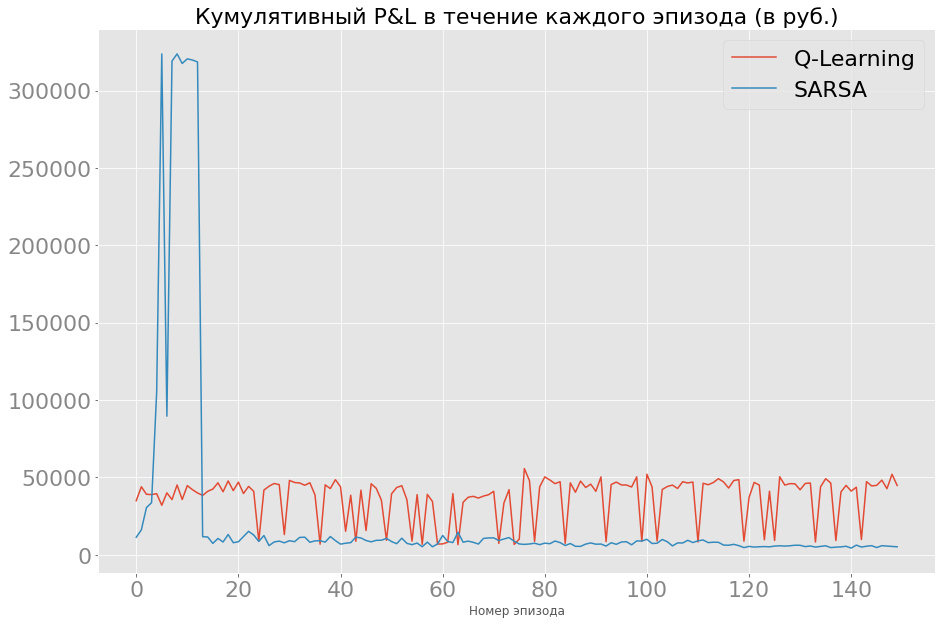

In [52]:
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_sarsa, label='SARSA')
plt.yticks(fontsize=22, alpha=.7)
plt.xticks(fontsize=22, alpha=.7)
plt.xlabel('Номер эпизода')
plt.title('Кумулятивный P&L в течение каждого эпизода (в руб.)', fontsize=22)
plt.legend(fontsize=22)

## Function for printing optimal policy of both agents

In [53]:
def print_optimal_policy(q_value):
    
    optimal_policy = np.argmax(q_value, axis=-1)
    print("ask fill prob:", *['%.2f' % q for q in  FILL_PROBS])
    
    for i in range(0, NUM_INV_STEPS):
        
        # positions ={'flat': 0, 'long': 2, 'short':1}
        str_=""
        if (i==0):
            str_ += '         flat     '
        elif(i==1):
            str_ += '        short     '
        else:
            str_ += '         long     '
            
        for j in range(0, NUM_PROB_STEPS): 
            a = np.int(optimal_policy[i,j])
            # actions = {'buy':2, 'sell':0, 'hold': 1}
            if a == 0:
                str_ += 's    '
            elif a ==1:
                str_ += 'h    ' 
            else:
                str_ += 'b    '  
        print(str_)

In [54]:
print_optimal_policy(q_sarsa)

ask fill prob: 0.00 0.11 0.22 0.33 0.44 0.56 0.67 0.78 0.89 1.00
         flat     b    b    b    b    b    b    s    s    s    s    
        short     h    h    b    b    h    h    h    h    h    b    
         long     s    s    s    s    s    s    s    s    s    s    


In [55]:
print_optimal_policy(q_q_learning)

ask fill prob: 0.00 0.11 0.22 0.33 0.44 0.56 0.67 0.78 0.89 1.00
         flat     b    b    b    b    b    s    s    s    b    s    
        short     b    h    h    b    h    b    b    b    b    b    
         long     h    s    s    s    s    s    s    s    s    s    


## Vizualization of taking learnt SARSA/Q-learning policy to test (not seen) data

In [56]:
t = pd.read_csv('LKOH20150311.csv')
data = t[['AskPrice1', 'AskVolume1', 'BidPrice1', 'BidVolume1']]
data.drop_duplicates(inplace=True)
data_RA = np.array(data)
data_generator = DataFeed(data_RA)

<ipython-input-56-6961724f7323>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)


## Need to choose SARSA or Q-learning

In [57]:
#view_strategy = q_q_learning
view_strategy = q_sarsa

<IPython.core.display.Javascript object>


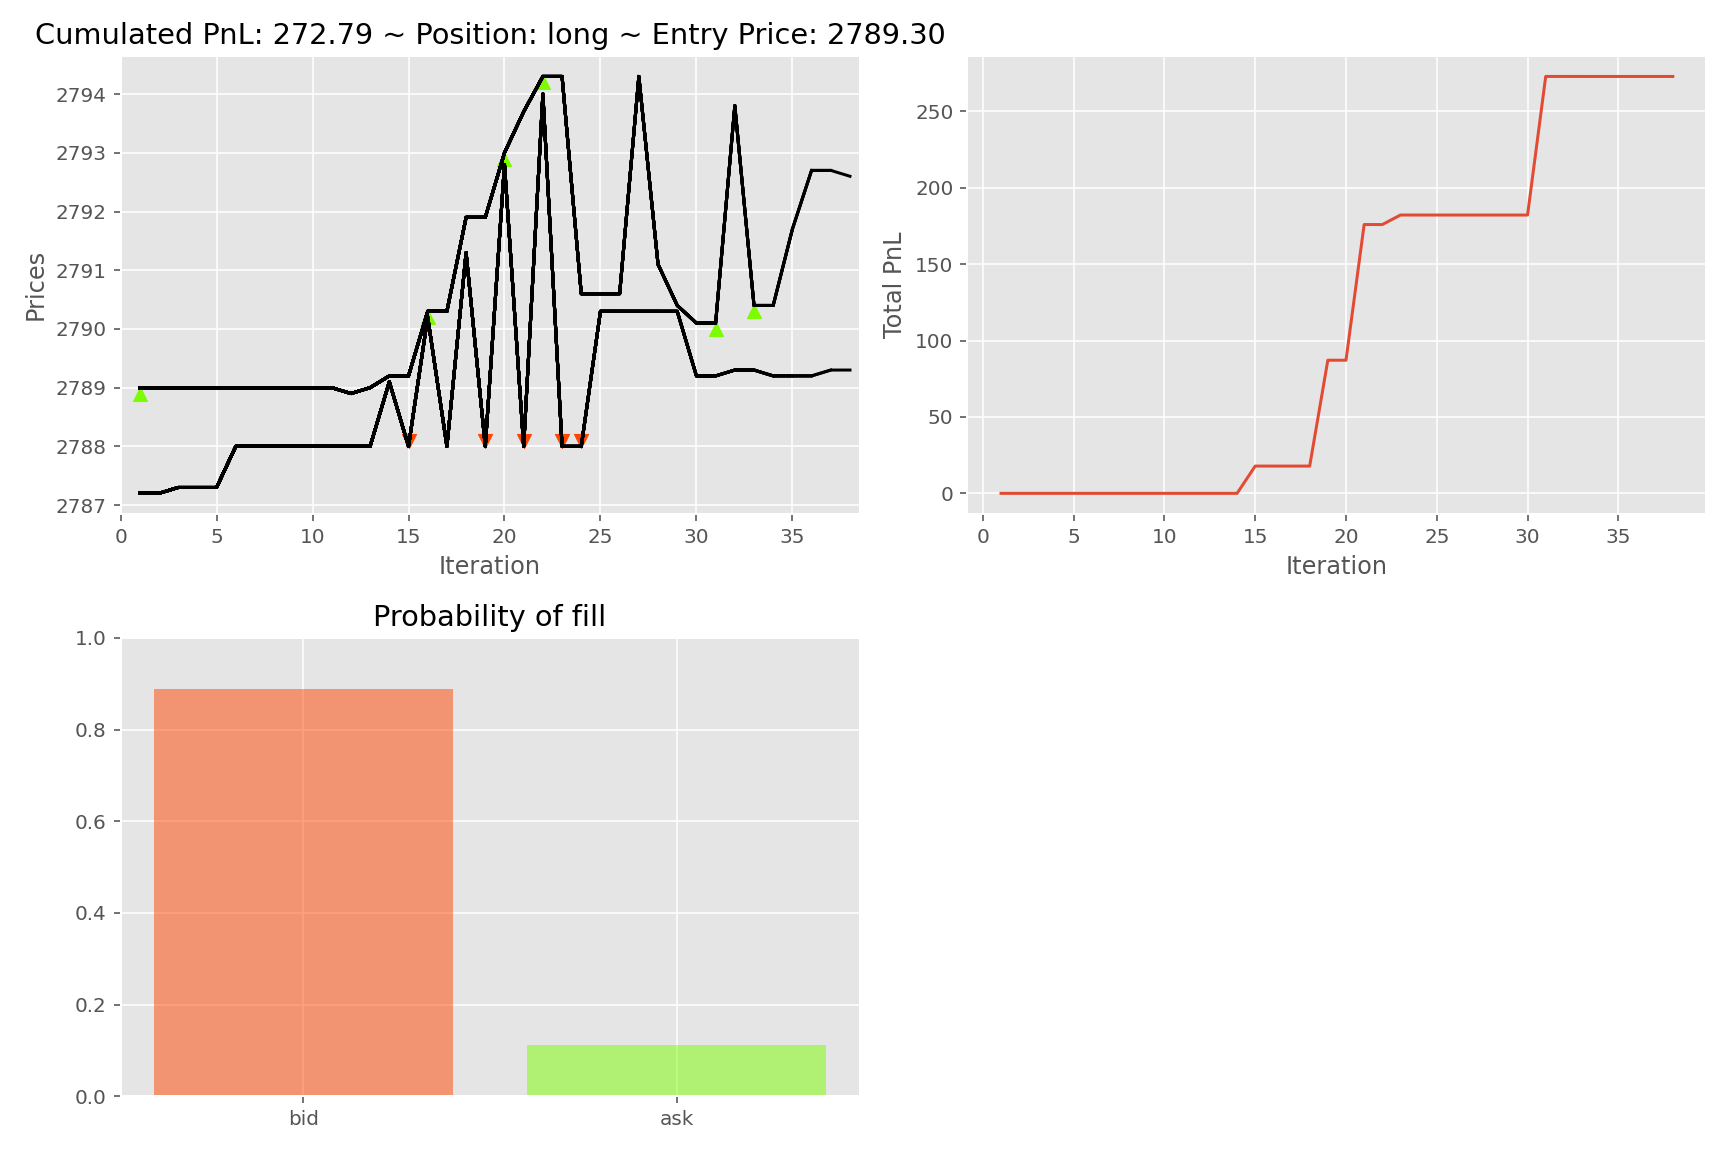

Animation stopped


In [58]:
%matplotlib nbagg
%matplotlib nbagg

fig = plt.figure(figsize=(12, 8))

gs = GridSpec(2,2) # 2 rows, 2 columns

ax1 = fig.add_subplot(gs[0,0]) # First row, first column
ax2 = fig.add_subplot(gs[0,1]) # First row, second column
ax3 = fig.add_subplot(gs[1,0]) # Second row, first column

bids = []
asks = []
bid_fills = []
xdata = []
pnl = []
action_names = []
bid_vols = []
ask_vols = []
amount_own = []
cash_limit_total = []

done = False
state = environment.reset()
rewards = 0.0
iteration = 0

while iteration < MAX_ITER and not done:
    try:
        start_time = time.time()
        prev_position_name = [name for name, pos in positions.items() if pos == state[0]][0] 
        
        action = np.argmax(view_strategy[state[0], state[1], :])
        try:
            state, reward, _ = environment.step(action)
        except StopIteration:
            done = True
            print('Stopped at time step', iteration)
            continue
        iteration += 1
        
        position_name = [name for name, pos in positions.items() if pos == state[0]][0] 
        action_name = [name for name, act in actions.items() if act == action][0]
        action_names.append(action_name)
        prices = state[2]
        if state[3] is None:
            entry_price = 'n/a'
        else:
            entry_price = "%.2f" % state[3]
        
        # Cumulative PnL
        if len(pnl) == 0:
            pnl.append(reward)
        else: 
            pnl.append(pnl[-1]+reward)

        bids.append(prices['bid'])
        asks.append(prices['ask'])
        bid_vols.append(state[6])
        ask_vols.append(state[7])
        amount_own.append(state[-1])
        cash_limit_total.append(state[-2])
        xdata.append(iteration)
        # Plot most recent 80 prices
        ax1.plot(xdata, 
                 bids, color = 'black')
        ax1.plot(xdata, 
                 asks, color = 'black')
        ax1.set_ylabel('Prices')
        ax1.set_xlabel('Iteration')
        ax1.set_title('Cumulated PnL: ' + "%.2f" % pnl[-1] + ' ~ '
                     + 'Position: ' + position_name + ' ~ '
                     + 'Entry Price: ' + entry_price)
        ax1.set_xlim([max(0, iteration - 80.5), iteration + 0.5])

        # Plotting actions taken according to the Policy
        if position_name != prev_position_name:
            if action == actions['sell']:
                ax1.scatter(iteration, prices['bid']+0.1, 
                        color='orangered', marker='v', s=50)
            elif action == actions['buy']:
                ax1.scatter(iteration, prices['ask']-0.1, 
                        color='lawngreen', marker='^', s=50)
        
        # Ploting PnL
        ax2.clear()
        ax2.plot(xdata, pnl)
        ax2.set_ylabel('Total PnL')
        ax2.set_xlabel('Iteration')

        # Plotting current probabilities to fill
        q_a = FILL_PROBS[state[1]]
        q_b = 1 - q_a
        performance = [q_b, q_a]

        ax3.clear()
        ax3.bar([0, 1], [q_b, q_a], align='center', alpha=0.5, 
                color=['orangered','lawngreen'])
        ax3.set_xticks([0, 1])
        ax3.set_xticklabels(['bid', 'ask'])
        ax3.set_title('Probability of fill')
        ax3.set_ylim([0, 1])
        fig.tight_layout()
        fig.canvas.draw()
        time.sleep(max(0, 0.5 - (time.time() - start_time)))
        
    except KeyboardInterrupt:
        print('Animation stopped')
        break

In [59]:
#print(len(action_names))
#print(pnl)
#print(action_names[:200])
#print(asks)
#print(bids[-50:])
#print(ask_vols)
#print(bid_vols[-50:])
#print(cash_limit_total[200:])
#print(amount_own[-50:])
#print(q_sarsa)
